# Notebook 6 - Extra figures from data analysis and modelling

#### This notebook is a part of a project with the Center for Systems Biology at the University of Iceland.


## Import modules:

In [1]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr

In [2]:
def impute_df(dataframe):
    '''
    A function to impute dataframe using KNN while still keeping the dataframe structure
    '''
    dat_columns = dataframe.columns
    dat_index = dataframe.index.tolist()
    imputah = KNNImputer()
    scalah = StandardScaler()
    dat_scaled = scalah.fit_transform(dataframe)
    dat_imputed = imputah.fit_transform(dat_scaled)
    dat_orig_transformed = scalah.inverse_transform(dat_imputed)
    return_df = pd.DataFrame(dat_orig_transformed, columns = dat_columns,index = dat_index)
    return return_df

def remove_columns_with_missing_data(dataframe,threshold_percentage):
    '''
    A function to remove columns from a dataframe that have more than threshold_percentage missing values
    '''
    # First remove rows that have NaN for all values:
    threshold_ = int(dataframe.shape[0]*(threshold_percentage/100))
    idx_remove = []
    for column_val in dataframe.columns:
        if dataframe[column_val].isna().sum() > threshold_:
            idx_remove.append(column_val)
    df_out = dataframe.drop(idx_remove, axis=1)
    return df_out

def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

In [3]:
mes = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/MEs_dataframe_24NOV2022.csv')
patients = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/patients_vector_24NOV2022.csv')
clin = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Database.csv',sep =';')
id_present = [idxx_ for idxx_,x in enumerate(clin['Subject Identifier for the Study'].tolist()) if x in patients['x'].tolist()]
clin = clin.iloc[id_present,:]
clin = clin.reset_index()

# Begin by getting only the clinical data with the non-outlier patient samples from the metabolomics network analysis: 
clin['sex_binary'] = clin['Sex']
clin['sex_binary'].replace('Male', 0,inplace=True)
clin['sex_binary'].replace('Female', 1,inplace=True)
clin['HTN_binary'] = clin['HTN']
clin['HTN_binary'].replace('Yes', 1,inplace=True)
clin['HTN_binary'].replace('No', 0,inplace=True)
clin['diabetes_binary'] = clin['Diabetes']
clin['diabetes_binary'].replace('Yes', 1,inplace=True)
clin['diabetes_binary'].replace('No', 0,inplace=True)
clin = clin.loc[:, clin.columns != 'Sex']
clin = clin.loc[:, clin.columns != 'HTN']
clin = clin.loc[:, clin.columns != 'Diabetes']

typess = clin.dtypes
for column_val in clin.columns[6:]:
    if typess[column_val] == 'O':
        clin[column_val] = clin[column_val].str.replace(',','.')
        clin[column_val] = pd.to_numeric(clin[column_val], errors='coerce')

# Remove clinical data with more than 10% missing data:
clin = remove_columns_with_missing_data(clin,20) 

# Select appropriate variables to keep in data:
clin_orig = clin.copy()
clin = clin[['sex_binary','BMI','Composite']]
clin = impute_df(clin)
clin_orig = impute_df(clin_orig)

# Round clin_orig subject identifier to integers:
clin_orig['Subject Identifier for the Study'] = round(clin_orig['Subject Identifier for the Study']).astype(int)
clin_orig = clin_orig.iloc[:,1:]

# Set response variable as integer:
clin['Composite'] = clin['Composite'].astype(int)
clin_orig['Composite'] = clin_orig['Composite'].astype(int)

# Load data from the network analysis in R:
mergedcolors = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/module_assignments_24NOV2022.csv')
findat = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/Final_dataframe_24NOV2022.csv')
datkme = pd.read_csv('C:/Users/sigurdur.karvelsson/OneDrive - Alvotech/Documents/Other/COVID_project_CSB/datkme_24NOV2022.csv')

# Prepare X and y data>
new_mes = pd.concat([mes,clin.loc[:, clin.columns != 'Composite']],axis = 1)
X = new_mes
y = clin['Composite']

## Model composite outcome based on specific clinical variables SAPS2, SOFA, NT-pro-BNP, Urea, Creatinine, Troponin and Platelets:

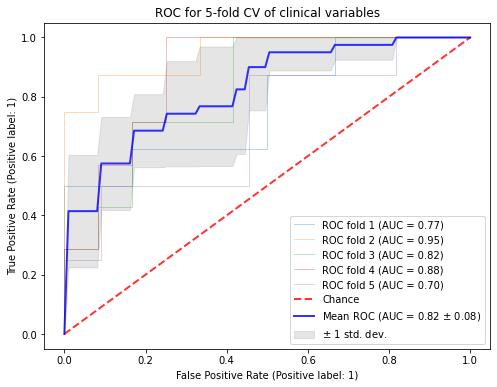

In [4]:
X_to_use = np.array(clin_orig[['SAPS2','SOFA','NT-pro-BNP','Urea','Creatinine','Troponin','Platelets']])
y_to_use = y.values

classifier = RandomForestClassifier()
# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}
classifier_opt = GridSearchCV(classifier, parameters, cv = 5)

# Fit on entire dataset to get optimal parameters:
classifier_opt.fit(X_to_use,y_to_use)
params_to_use = classifier_opt.best_estimator_.get_params()

cv = StratifiedKFold(n_splits=5)
classifier_for_cv = RandomForestClassifier(**params_to_use)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

importance_list = []

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X_to_use, y_to_use)):
    classifier_for_cv.fit(X_to_use[train], y_to_use[train])
    importance_list.append(classifier_for_cv.feature_importances_)
    #scores = classifier_for_cv.predict_proba(X_to_use[test])[:,1]
    #aucc = roc_auc_score(y_to_use[test],scores)
    viz = RocCurveDisplay.from_estimator(
        classifier_for_cv,
        X_to_use[test],
        y_to_use[test],
        name="ROC fold {}".format(i+1),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #fpr, tpr, thresholds = roc_curve(y_to_use[test], scores, pos_label=2)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#mean_auc = np.mean(auc)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for 5-fold CV of clinical variables",
)
ax.legend(loc="lower right")
plt.show()

## Model composite outcome based on previous clinical variables in addition to the three top features from the random forest model in Notebook 5:

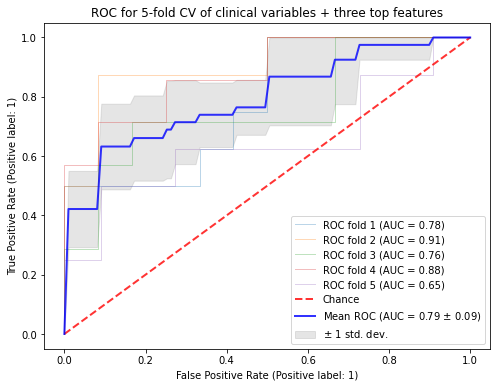

In [5]:
X_to_use = np.array(pd.concat([findat[['pos_mz_516.3008798','pos_mz_114.066238','pos_mz_182.0808902']],
                      clin_orig[['SAPS2','SOFA','NT-pro-BNP','Urea','Creatinine','Troponin','Platelets']]], axis = 1))
y_to_use = y.values

classifier = RandomForestClassifier()
# Try out a grid of parameters:
parameters = {'max_features':np.arange(2,4),'n_estimators':[1000,2000],'max_depth':[2,3,4], 'random_state':[0]}
classifier_opt = GridSearchCV(classifier, parameters, cv = 5)

# Fit on entire dataset to get optimal parameters:
classifier_opt.fit(X_to_use,y_to_use)
params_to_use = classifier_opt.best_estimator_.get_params()

cv = StratifiedKFold(n_splits=5)
classifier_for_cv = RandomForestClassifier(**params_to_use)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

importance_list = []

fig, ax = plt.subplots(figsize=(8,6))
for i, (train, test) in enumerate(cv.split(X_to_use, y_to_use)):
    classifier_for_cv.fit(X_to_use[train], y_to_use[train])
    importance_list.append(classifier_for_cv.feature_importances_)
    #scores = classifier_for_cv.predict_proba(X_to_use[test])[:,1]
    #aucc = roc_auc_score(y_to_use[test],scores)
    viz = RocCurveDisplay.from_estimator(
        classifier_for_cv,
        X_to_use[test],
        y_to_use[test],
        name="ROC fold {}".format(i+1),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    #fpr, tpr, thresholds = roc_curve(y_to_use[test], scores, pos_label=2)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#mean_auc = np.mean(auc)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for 5-fold CV of clinical variables + three top features",
)
ax.legend(loc="lower right")
plt.show()

## Check correlation between clinical creatinine levels and metabolomic creatinine levels:

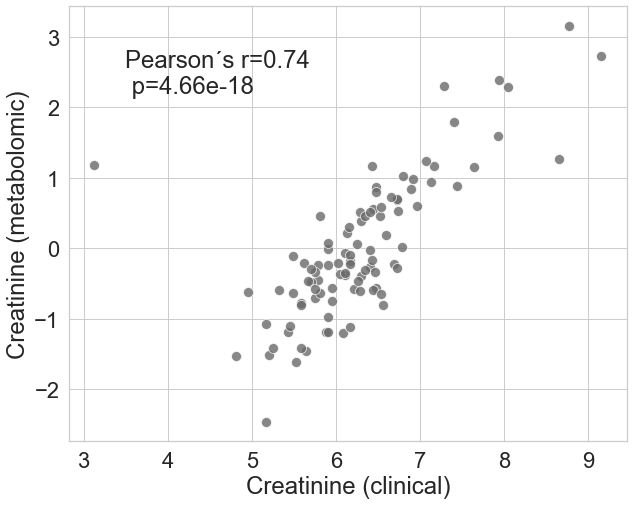

In [6]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
colors = ["dimgrey"]
sns.set_palette(sns.color_palette(colors))

glog = lambda x: np.log2((x+np.sqrt(x**2+1))/2) # Same transformation as was made to the metabolomic data

new_dat = pd.DataFrame([findat['pos_mz_114.066238'],glog(clin_orig['Creatinine'])]).T
new_dat.columns = ['Creatinine (metabolomic)','Creatinine (clinical)']

ax = sns.scatterplot(data=new_dat,x = 'Creatinine (clinical)',y = 'Creatinine (metabolomic)', alpha=0.8, s = 100)
r, p = pearsonr(new_dat['Creatinine (clinical)'],new_dat['Creatinine (metabolomic)'])
ax.text(.1, .8, 'Pearson´s r={:.2f}\n p={:.2e}'.format(r,p), transform=ax.transAxes)
plt.show()


## Find which clinical variables might correlate with the m/z 516.3008 peak from the metabolomic data:

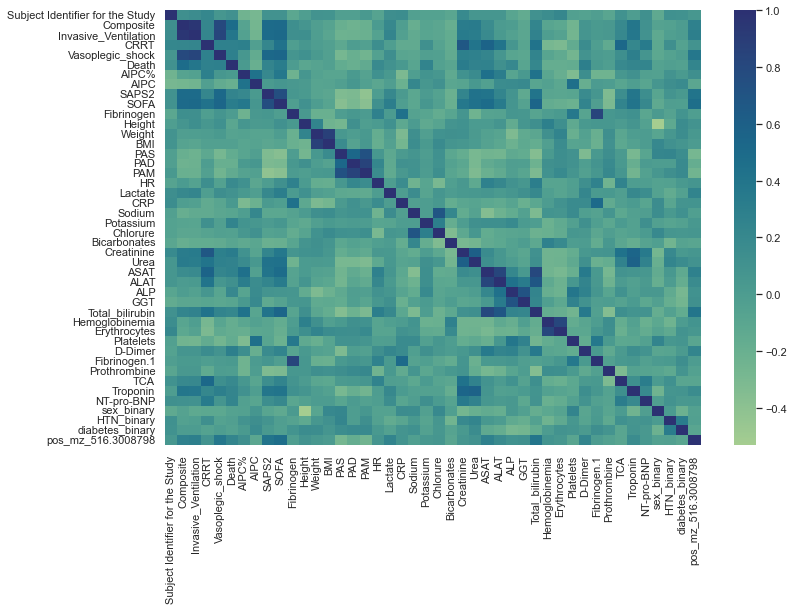

In [7]:
sns.set(font_scale=1)
test_dat = pd.concat([clin_orig, findat['pos_mz_516.3008798']],axis = 1)
corr = test_dat.corr(method = 'pearson')

# plot the heatmap
plt.figure(figsize = (12,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap = 'crest')
plt.show()

## It appears that there is correlation between m/z 516.3008 and total bilirubin levels. Plot their association and display the correlation value:

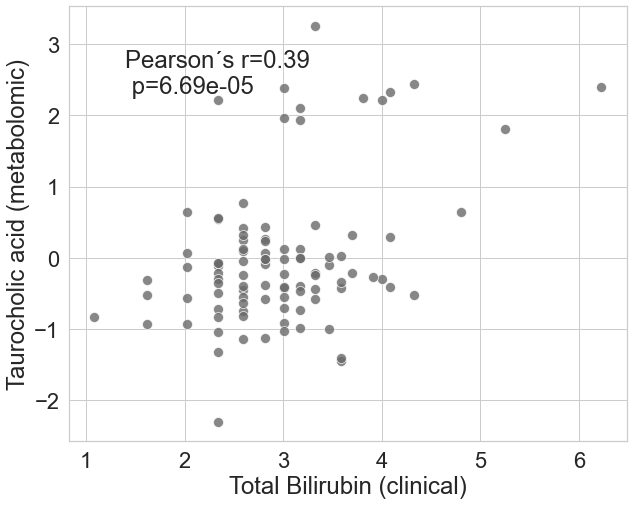

In [8]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
colors = ["dimgrey"]
sns.set_palette(sns.color_palette(colors))
pearsonr(glog(clin_orig['Total_bilirubin']),findat['pos_mz_516.3008798'])


new_dat = pd.DataFrame([findat['pos_mz_516.3008798'],glog(clin_orig['Total_bilirubin'])]).T
new_dat.columns = ['Taurocholic acid (metabolomic)','Total Bilirubin (clinical)']

ax = sns.scatterplot(data=new_dat,x = 'Total Bilirubin (clinical)',y = 'Taurocholic acid (metabolomic)', alpha=0.8, s = 100)
r, p = pearsonr(new_dat['Total Bilirubin (clinical)'],new_dat['Taurocholic acid (metabolomic)'])
ax.text(.1, .8, 'Pearson´s r={:.2f}\n p={:.2e}'.format(r,p), transform=ax.transAxes)
plt.show()